<a href="https://colab.research.google.com/github/abrar360/AngelsDevilsRL/blob/master/SBS_SCAN_Mobiact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
# !pip install wandb
import faiss

import warnings
warnings.filterwarnings("ignore")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Requirement already up-to-date: faiss in /usr/local/lib/python3.7/dist-packages (1.5.3)
Requirement already up-to-date: faiss-gpu in /usr/local/lib/python3.7/dist-packages (1.7.0)


In [203]:
# import wandb

In [204]:
# !wandb login

# wandb.init(project="SBS SCAN Motionsense", config={
#     "entropy_weight": 0.0,
#     "balance": False,
# })

In [205]:
# config = wandb.config

In [206]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv1d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        #self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                #nn.BatchNorm1d(self.expansion * planes)
            )

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        # out = self.bn2(self.conv2(out))
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, device, in_channel=6, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.device = device
        self.in_planes = 64

        self.conv1 = nn.Conv1d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        #self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AvgPool1d(7, stride=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves
        # like an identity. This improves the model by 0.2~0.3% according to:
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0,2,1).float().to(self.device)
        #out = self.maxpool(F.relu(self.bn1(self.conv1(x))))
        out = self.maxpool(F.relu(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out


def resnet18(device, **kwargs):
    return {'backbone': ResNet(BasicBlock, [2, 2, 2, 2], device, **kwargs), 'dim': 512}

class ContrastiveModelX(nn.Module):
    def __init__(self, backbone, device, head='mlp', features_dim=128):
        super(ContrastiveModelX, self).__init__()
        self.backbone = backbone['backbone']
        self.backbone_dim = backbone['dim']
        self.head = head
        self.device = device
 
        if head == 'linear':
            self.contrastive_head = nn.Linear(self.backbone_dim, features_dim)

        elif head == 'mlp':
            self.contrastive_head = nn.Sequential(
                    nn.Linear(self.backbone_dim, self.backbone_dim),
                    nn.ReLU(), nn.Linear(self.backbone_dim, features_dim))
        
        else:
            raise ValueError('Invalid head {}'.format(head))

    def forward(self, x):
        bneck = self.backbone(x)
        features = self.contrastive_head(bneck)
        features = F.normalize(features, dim = 1)
        return features

In [207]:
NUM_CHANNELS = 6
SLIDING_WINDOW_LENGTH = 100
class Encoder(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        self.device = device

        self.conv1 = nn.Conv1d(NUM_CHANNELS, 32, 3, padding=1, padding_mode='reflect', bias=False)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1, padding_mode='reflect', bias=False)
        self.conv3 = nn.Conv1d(64, 128, 3, padding=1, padding_mode='reflect', bias=False)
        self.pool = nn.MaxPool1d(SLIDING_WINDOW_LENGTH)
        self.drop = nn.Dropout(p=0.2)



    def forward(self, features):
        features = features.to(self.device).permute(0,2,1).float()
        x = self.conv1(features)
        x = F.relu(x)
        x = self.drop(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.drop(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.pool(x)
        x = x.reshape((-1, 128))
        x = F.normalize(x, dim=1)

        return x

class ClusteringModel(nn.Module):
    def __init__(self, backbone, nclusters, nheads=1):
        super(ClusteringModel, self).__init__()
        self.backbone = backbone
        self.backbone_dim = 512
        self.nheads = nheads
        assert(isinstance(self.nheads, int))
        assert(self.nheads > 0)
        self.cluster_head = nn.ModuleList([nn.Linear(self.backbone_dim, nclusters) for _ in range(self.nheads)])

    def forward(self, x, forward_pass='default'):
        if forward_pass == 'default':
            features = self.backbone(x)
            out = [cluster_head(features) for cluster_head in self.cluster_head]

        elif forward_pass == 'backbone':
            out = self.backbone(x)

        elif forward_pass == 'head':
            out = [cluster_head(x) for cluster_head in self.cluster_head]

        elif forward_pass == 'return_all':
            features = self.backbone(x)
            out = {'features': features, 'output': [cluster_head(features) for cluster_head in self.cluster_head]}
        
        else:
            raise ValueError('Invalid forward pass {}'.format(forward_pass))        

        return out

In [208]:
class MemoryBank(object):
    def __init__(self, n, dim, num_classes, temperature):
        self.n = n
        self.dim = dim 
        self.features = torch.FloatTensor(self.n, self.dim)
        self.targets = torch.LongTensor(self.n)
        self.ptr = 0
        self.device = 'cpu'
        self.K = 100
        self.temperature = temperature
        self.C = num_classes

    def weighted_knn(self, predictions):
        # perform weighted knn
        retrieval_one_hot = torch.zeros(self.K, self.C).to(self.device)
        batchSize = predictions.shape[0]
        correlation = torch.matmul(predictions, self.features.t())
        yd, yi = correlation.topk(self.K, dim=1, largest=True, sorted=True)
        candidates = self.targets.view(1,-1).expand(batchSize, -1)
        retrieval = torch.gather(candidates, 1, yi)
        retrieval_one_hot.resize_(batchSize * self.K, self.C).zero_()
        retrieval_one_hot.scatter_(1, retrieval.view(-1, 1), 1)
        yd_transform = yd.clone().div_(self.temperature).exp_()
        probs = torch.sum(torch.mul(retrieval_one_hot.view(batchSize, -1 , self.C), 
                          yd_transform.view(batchSize, -1, 1)), 1)
        _, class_preds = probs.sort(1, True)
        class_pred = class_preds[:, 0]

        return class_pred

    def knn(self, predictions):
        # perform knn
        correlation = torch.matmul(predictions, self.features.t())
        sample_pred = torch.argmax(correlation, dim=1)
        class_pred = torch.index_select(self.targets, 0, sample_pred)
        return class_pred

    def mine_nearest_neighbors(self, topk, calculate_accuracy=True):
        # mine the topk nearest neighbors for every sample
        import faiss
        features = self.features.cpu().numpy()
        n, dim = features.shape[0], features.shape[1]
        index = faiss.IndexFlatIP(dim)
        index = faiss.index_cpu_to_all_gpus(index)
        index.add(features)
        distances, indices = index.search(features, topk+1) # Sample itself is included
        
        # evaluate 
        if calculate_accuracy:
            targets = self.targets.cpu().numpy()
            neighbor_targets = np.take(targets, indices[:,1:], axis=0) # Exclude sample itself for eval
            anchor_targets = np.repeat(targets.reshape(-1,1), topk, axis=1)
            accuracy = np.mean(neighbor_targets == anchor_targets)
            return indices, accuracy
        
        else:
            return indices

    def reset(self):
        self.ptr = 0 
        
    def update(self, features, targets):
        b = features.size(0)
        
        assert(b + self.ptr <= self.n)
        
        self.features[self.ptr:self.ptr+b].copy_(features.detach())
        self.targets[self.ptr:self.ptr+b].copy_(targets.detach())
        self.ptr += b

    def to(self, device):
        self.features = self.features.to(device)
        self.targets = self.targets.to(device)
        self.device = device

    def cpu(self):
        self.to('cpu')

    def cuda(self):
        self.to('cuda:0')

In [209]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
BOTTLENECK_DIM = 128
class RAE_old(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()
        self.device = device
        self.GRU_encoder = nn.GRU(input_size=NUM_CHANNELS, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)
        

        self.bottleneck = nn.Linear(512, BOTTLENECK_DIM)


        self.GRU_decoder1 = nn.GRU(input_size=BOTTLENECK_DIM, hidden_size=256, num_layers=2, batch_first=True, bidirectional=False)
        self.lin1 = nn.Linear(256, NUM_CHANNELS)
        self.GRU_decoder2 = nn.GRU(input_size=BOTTLENECK_DIM, hidden_size=256, num_layers=2, batch_first=True, bidirectional=False)
        self.lin2 = nn.Linear(256, NUM_CHANNELS)


    def forward(self, features):
        features = features.to(self.device)
        x, _ = self.GRU_encoder(features) # feed inputs through GRU bidirectional encoder to obtain (batch_size, 64, 512) 
        x = x[:, -1, :] # take the output from the final timestep to get dim = (batch_size, 512)
        bottleneck = self.bottleneck(x) # pass it through a linear layer to obtain (batch_size, 64) dim bottleneck embeddings
        bottleneck = F.normalize(bottleneck, dim=1)

        return bottleneck


In [211]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# backbone = resnet18(device)
# model = ContrastiveModelX(backbone, device)
model = Encoder(device)#
#checkpoint = torch.load("/content/drive/MyDrive/ContrastiveLearningHAR-main/ContrastiveLearningHAR-main/simclr_motionsense.pth", map_location='cpu')#
checkpoint = torch.load("/content/drive/MyDrive/ContrastiveLearningHAR-main/ContrastiveLearningHAR-main/simclr_mobiact_mining.pth", map_location='cpu')
#checkpoint = torch.load("dsc_mobiact_CAE (1).pth", map_location='cpu')
model.load_state_dict(checkpoint, strict=False)#
model = model.to(device)#

# backbone = resnet18(device)
# mod = ContrastiveModelX(backbone, device)
# checkpoint = torch.load("/content/drive/MyDrive/ContrastiveLearningHAR-main/ContrastiveLearningHAR-main/best_model_resnet_mobi.pth", map_location='cpu')
# mod.load_state_dict(checkpoint)
# model = mod.to(device)

In [212]:
# checkpoint = torch.load("/content/drive/MyDrive/ContrastiveLearningHAR-main/ContrastiveLearningHAR-main/best_model_full.pth", map_location='cpu')
# model.load_state_dict(checkpoint)
# model = model.to(device)

In [213]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [214]:
import torchvision
from torchvision import transforms
    
def get_val_dataloader(dataset):
    return torch.utils.data.DataLoader(dataset, num_workers=8,
            batch_size=512, pin_memory=True, collate_fn=collate_custom,
            drop_last=False, shuffle=False)
    
def collate_custom(batch):
    if isinstance(batch[0], np.int64):
        return np.stack(batch, 0)

    if isinstance(batch[0], torch.Tensor):
        return torch.stack(batch, 0)

    elif isinstance(batch[0], np.ndarray):
        return np.stack(batch, 0)

    elif isinstance(batch[0], int_classes):
        return torch.LongTensor(batch)

    elif isinstance(batch[0], float):
        return torch.FloatTensor(batch)

    elif isinstance(batch[0], string_classes):
        return batch

    elif isinstance(batch[0], collections.Mapping):
        batch_modified = {key: collate_custom([d[key] for d in batch]) for key in batch[0] if key.find('idx') < 0}
        return batch_modified

    elif isinstance(batch[0], collections.Sequence):
        transposed = zip(*batch)
        return [collate_custom(samples) for samples in transposed]

    raise TypeError(('Type is {}'.format(type(batch[0]))))

In [215]:
import scipy.io as sio
from torch.utils.data.dataset import Dataset
import numpy as np

class HARDataset(Dataset):
    def __init__(self, dp, lab):
        self.datapoints = dp
        self.labels = lab
        
        
    def __getitem__(self, index):
        data = self.datapoints[index]
        data = torch.from_numpy(data)

        label = self.labels[index]
        label = torch.tensor(label)

        return data,label

    def __len__(self):
        return len(self.labels)

dataset = sio.loadmat("/content/drive/My Drive/pytorch_experiments/mobiactv2_6_sr_50.mat")

X_tr = dataset['X_train']
y_tr = dataset['y_train'].reshape(-1).astype(int)
X_va = dataset['X_valid']
y_va = dataset['y_valid'].reshape(-1).astype(int)
X_te = dataset['X_test']
y_te = dataset['y_test'].reshape(-1).astype(int)


print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)
print(X_te.shape)
print(y_te.shape)

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

for i in range(0, X_tr.shape[0], SLIDING_WINDOW_LENGTH):
    if i+SLIDING_WINDOW_LENGTH <= X_tr.shape[0]+1:
        X_train.append(X_tr[i:i+SLIDING_WINDOW_LENGTH, :])
        y_train.append(np.bincount(y_tr[i:i+SLIDING_WINDOW_LENGTH]).argmax())
for i in range(0, X_va.shape[0], SLIDING_WINDOW_LENGTH):
    if i+SLIDING_WINDOW_LENGTH <= X_va.shape[0]+1:
        X_val.append(X_va[i:i+SLIDING_WINDOW_LENGTH, :])
        y_val.append(np.bincount(y_va[i:i+SLIDING_WINDOW_LENGTH]).argmax())
for i in range(0, X_te.shape[0], SLIDING_WINDOW_LENGTH):
    if i+SLIDING_WINDOW_LENGTH <= X_te.shape[0]+1:
        X_test.append(X_te[i:i+SLIDING_WINDOW_LENGTH, :])
        y_test.append(np.bincount(y_te[i:i+SLIDING_WINDOW_LENGTH]).argmax())

def balance_data(X, y):
    X = np.array(X)
    y = np.array(y)
    newX = [X]
    newy = [y]
    dist = np.bincount(y)
    max_class = dist.max()
    for i in range(dist.shape[0]):
        diff = max_class - dist[i]
        if diff > 0:
            if diff > dist[i]:
                n = diff//dist[i]
                newX.append(np.vstack([X[np.where(y==i)[0]]] * n))
                newy.append(np.ones(n*dist[i]) * i)
            ind = np.random.choice(dist[i], diff%dist[i])
            newX.append(X[np.where(y==i)[0][ind]])
            newy.append(np.ones(diff%dist[i])*i)
    return np.vstack(newX), np.hstack(newy).astype(int)

X_train, y_train = balance_data(X_train, y_train)

ind = []
for i in range(11):
    que = np.random.choice(np.where(np.array(y_train) == i)[0], 2000) #2000
    ind += que.tolist()

X_train = np.array(X_train)[ind]
y_train = np.array(y_train)[ind]

print("Train", len(X_train), len(y_train))
print("Val", len(X_val), len(y_val))
print("Test", len(X_test), len(y_test))

base_dataset = HARDataset(X_train, y_train)
val_dataset = HARDataset(X_val, y_val)
test_dataset = HARDataset(X_test, y_test)

(1935124, 6)
(1935124,)
(516409, 6)
(516409,)
(654853, 6)
(654853,)
Train 22000 22000
Val 5164 5164
Test 6548 6548


In [216]:
print(np.bincount(np.array(y_train)))

[2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000]


In [217]:
memory_bank_base = MemoryBank(len(base_dataset), 
                                128,
                                11, 0.1)
memory_bank_val = MemoryBank(len(val_dataset), 
                                128,
                                11, 0.1)
memory_bank_test = MemoryBank(len(test_dataset), 
                                128,
                                11, 0.1)
  
memory_bank_base.to(device)
memory_bank_val.to(device)
memory_bank_test.to(device)

In [218]:
@torch.no_grad()
def fill_memory_bank(loader, model, memory_bank):
    model.eval()
    memory_bank.reset()

    for i, (x, y) in enumerate(loader):
        images = x.cuda(non_blocking=True)
        targets = y.cuda(non_blocking=True)
        output = model(images.float())
        memory_bank.update(output, targets)
        if i % 100 == 0:
            print('Fill Memory Bank [%d/%d]' %(i, len(loader)))


In [219]:
import numpy as np
from torch._six import string_classes, int_classes
import collections

base_dataloader = get_val_dataloader(base_dataset)
val_dataloader = get_val_dataloader(val_dataset) 
test_dataloader = get_val_dataloader(test_dataset)
fill_memory_bank(base_dataloader, model, memory_bank_base)
topk = 20
print('Mine the nearest neighbors (Top-%d)' %(topk)) 
train_indices, acc = memory_bank_base.mine_nearest_neighbors(topk)
print('Accuracy of top-%d nearest neighbors on train set is %.2f' %(topk, 100*acc))

Fill Memory Bank [0/43]
Mine the nearest neighbors (Top-20)
Accuracy of top-20 nearest neighbors on train set is 90.51


In [220]:
fill_memory_bank(val_dataloader, model, memory_bank_val)
topk = 5
print('Mine the nearest neighbors (Top-%d)' %(topk)) 
val_indices, acc = memory_bank_val.mine_nearest_neighbors(topk)
print('Accuracy of top-%d nearest neighbors on val set is %.2f' %(topk, 100*acc))

Fill Memory Bank [0/11]
Mine the nearest neighbors (Top-5)
Accuracy of top-5 nearest neighbors on val set is 93.68


In [221]:
fill_memory_bank(test_dataloader, model, memory_bank_test)
topk = 5
print('Mine the nearest neighbors (Top-%d)' %(topk)) 
test_indices, acc = memory_bank_test.mine_nearest_neighbors(topk)
print('Accuracy of top-%d nearest neighbors on val set is %.2f' %(topk, 100*acc))

Fill Memory Bank [0/13]
Mine the nearest neighbors (Top-5)
Accuracy of top-5 nearest neighbors on val set is 92.68


In [222]:
from torch.utils.data import Dataset

class NeighborsDataset(Dataset):
    def __init__(self, dataset, indices, num_neighbors=None):
        super(NeighborsDataset, self).__init__()

        self.dataset = dataset
        self.indices = indices # Nearest neighbor indices (np.array  [len(dataset) x k])
        if num_neighbors is not None:
            self.indices = self.indices[:, :num_neighbors+1]
        assert(self.indices.shape[0] == len(self.dataset))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        output = {}
        anchor = self.dataset.__getitem__(index)
        anchor = {'image':anchor[0], 'target':anchor[1]}
        
        neighbor_index = np.random.choice(self.indices[index], 1)[0]
        neighbor = self.dataset.__getitem__(neighbor_index)
        neighbor = {'image':neighbor[0], 'target':neighbor[1]}

        output['anchor'] = anchor['image']
        output['neighbor'] = neighbor['image'] 
        output['possible_neighbors'] = torch.from_numpy(self.indices[index])
        output['target'] = anchor['target']
        
        return output


In [223]:
train_dataset = HARDataset(X_train, y_train)

def get_train_dataloader(dataset):
    return torch.utils.data.DataLoader(dataset, num_workers=8, 
            batch_size=128, pin_memory=True, collate_fn=collate_custom,
            drop_last=True, shuffle=True)
    
def get_val_dataloader(dataset):
    return torch.utils.data.DataLoader(dataset, num_workers=8,
            batch_size=128, pin_memory=True, collate_fn=collate_custom,
            drop_last=False, shuffle=False)

  
train_dataset = NeighborsDataset(train_dataset, train_indices[:, 1:], 20) #try changing these
val_dataset = NeighborsDataset(val_dataset, val_indices[:, 1:], 5)
test_dataset = NeighborsDataset(test_dataset, test_indices[:, 1:], 5)

train_dataloader = get_train_dataloader(train_dataset)
trview_dataloader = get_val_dataloader(train_dataset)
val_dataloader = get_val_dataloader(val_dataset)
test_dataloader = get_val_dataloader(test_dataset)
print('Train samples %d - Val samples %d' %(len(train_dataset), len(val_dataset)))

Train samples 22000 - Val samples 5164


In [224]:
def entropy(x, input_as_probabilities):
    """ 
    Helper function to compute the entropy over the batch 
    input: batch w/ shape [b, num_classes]
    output: entropy value [is ideally -log(num_classes)]
    """
    EPS=1e-8
    if input_as_probabilities:
        x_ =  torch.clamp(x, min = EPS)
        b =  x_ * torch.log(x_)
    else:
        b = F.softmax(x, dim = 1) * F.log_softmax(x, dim = 1)

    if len(b.size()) == 2: # Sample-wise entropy
        return -b.sum(dim = 1).mean()
    elif len(b.size()) == 1: # Distribution-wise entropy
        return - b.sum()
    else:
        raise ValueError('Input tensor is %d-Dimensional' %(len(b.size())))

class SCANLoss(nn.Module):
    def __init__(self, entropy_weight = 2.0):
        super(SCANLoss, self).__init__()
        self.softmax = nn.Softmax(dim = 1)
        self.bce = nn.BCELoss()
        self.entropy_weight = entropy_weight # Default = 2.0

    def forward(self, anchors, neighbors):
        """
        input:
            - anchors: logits for anchor images w/ shape [b, num_classes]
            - neighbors: logits for neighbor images w/ shape [b, num_classes]
        output:
            - Loss
        """
        # Softmax
        b, n = anchors.size()
        anchors_prob = self.softmax(anchors)
        positives_prob = self.softmax(neighbors)
       
        # Similarity in output space
        similarity = torch.bmm(anchors_prob.view(b, 1, n), positives_prob.view(b, n, 1)).squeeze()
        ones = torch.ones_like(similarity)
        consistency_loss = self.bce(similarity, ones)
        
        # Entropy loss
        entropy_loss = entropy(torch.mean(anchors_prob, 0), input_as_probabilities = True)

        # Total loss
        total_loss = consistency_loss - self.entropy_weight * entropy_loss
        
        return total_loss, consistency_loss, entropy_loss

In [225]:
def scan_train(train_loader, model, criterion, optimizer, epoch, update_cluster_head_only=False):
    """ 
    Train w/ SCAN-Loss
    """
    total_losses = AverageMeter('Total Loss', ':.4e')
    consistency_losses = AverageMeter('Consistency Loss', ':.4e')
    entropy_losses = AverageMeter('Entropy', ':.4e')
    progress = ProgressMeter(len(train_loader),
        [total_losses, consistency_losses, entropy_losses],
        prefix="Epoch: [{}]".format(epoch))

    if update_cluster_head_only:
        model.eval() # No need to update BN
    else:
        model.train() # Update BN

    for i, batch in enumerate(train_loader):
        # Forward pass
        anchors = batch['anchor'].cuda(non_blocking=True)
        neighbors = batch['neighbor'].cuda(non_blocking=True)
       
        if update_cluster_head_only: # Only calculate gradient for backprop of linear layer
            with torch.no_grad():
                anchors_features = model(anchors, forward_pass='backbone')
                neighbors_features = model(neighbors, forward_pass='backbone')
            anchors_output = model(anchors_features, forward_pass='head')
            neighbors_output = model(neighbors_features, forward_pass='head')

        else: # Calculate gradient for backprop of complete network
            anchors_output = model(anchors)
            neighbors_output = model(neighbors)     

        # Loss for every head
        total_loss, consistency_loss, entropy_loss = [], [], []
        for anchors_output_subhead, neighbors_output_subhead in zip(anchors_output, neighbors_output):
            total_loss_, consistency_loss_, entropy_loss_ = criterion(anchors_output_subhead,
                                                                         neighbors_output_subhead)
            total_loss.append(total_loss_)
            consistency_loss.append(consistency_loss_)
            entropy_loss.append(entropy_loss_)

        # Register the mean loss and backprop the total loss to cover all subheads
        total_losses.update(np.mean([v.item() for v in total_loss]))
        consistency_losses.update(np.mean([v.item() for v in consistency_loss]))
        entropy_losses.update(np.mean([v.item() for v in entropy_loss]))

        total_loss = torch.sum(torch.stack(total_loss, dim=0))

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if i % 25 == 0:
            progress.display(i)

@torch.no_grad()
def get_predictions(dataloader, model, return_features=False):
    # Make predictions on a dataset with neighbors
    model.eval()
    predictions = [[] for _ in range(1)]
    probs = [[] for _ in range(1)]
    targets = []
    if return_features:
        ft_dim = 512
        features = torch.zeros((len(dataloader.sampler), ft_dim)).cuda()
    
    if isinstance(dataloader.dataset, NeighborsDataset): # Also return the neighbors
        key_ = 'anchor'
        include_neighbors = True
        neighbors = []

    else:
        key_ = 0
        include_neighbors = False

    ptr = 0
    for batch in dataloader:
        images = batch[key_].cuda(non_blocking=True)
        bs = images.shape[0]
        res = model(images, forward_pass='return_all')
        output = res['output']
        if return_features:
            features[ptr: ptr+bs] = res['features']
            ptr += bs
        for i, output_i in enumerate(output):
            predictions[i].append(torch.argmax(output_i, dim=1))
            probs[i].append(F.softmax(output_i, dim=1))
        if key_ == 'anchor':
            targets.append(batch['target'])
        else:
            targets.append(batch[1])
        if include_neighbors:
            neighbors.append(batch['possible_neighbors'])

    predictions = [torch.cat(pred_, dim = 0).cpu() for pred_ in predictions]
    probs = [torch.cat(prob_, dim=0).cpu() for prob_ in probs]
    targets = torch.cat(targets, dim=0)

    if include_neighbors:
        neighbors = torch.cat(neighbors, dim=0)
        out = [{'predictions': pred_, 'probabilities': prob_, 'targets': targets, 'neighbors': neighbors} for pred_, prob_ in zip(predictions, probs)]

    else:
        out = [{'predictions': pred_, 'probabilities': prob_, 'targets': targets} for pred_, prob_ in zip(predictions, probs)]

    if return_features:
        return out, features.cpu()
    else:
        return out

@torch.no_grad()
def scan_evaluate(predictions):
    # Evaluate model based on SCAN loss.
    num_heads = len(predictions)
    output = []

    for head in predictions:
        # Neighbors and anchors
        probs = head['probabilities']
        neighbors = head['neighbors']
        anchors = torch.arange(neighbors.size(0)).view(-1,1).expand_as(neighbors)

        # Entropy loss
        entropy_loss = entropy(torch.mean(probs, dim=0), input_as_probabilities=True).item()
        
        # Consistency loss       
        similarity = torch.matmul(probs, probs.t())
        neighbors = neighbors.contiguous().view(-1)
        anchors = anchors.contiguous().view(-1)
        similarity = similarity[anchors, neighbors]
        ones = torch.ones_like(similarity)
        consistency_loss = F.binary_cross_entropy(similarity, ones).item()
        
        # Total loss
        total_loss = - entropy_loss + consistency_loss
        
        output.append({'entropy': entropy_loss, 'consistency': consistency_loss, 'total_loss': total_loss})

    total_losses = [output_['total_loss'] for output_ in output]
    lowest_loss_head = np.argmin(total_losses)
    lowest_loss = np.min(total_losses)

    return {'scan': output, 'lowest_loss_head': lowest_loss_head, 'lowest_loss': lowest_loss}

In [226]:
backbone = resnet18(device)
mod = ContrastiveModelX(backbone, device)
checkpoint = torch.load("/content/drive/MyDrive/ContrastiveLearningHAR-main/ContrastiveLearningHAR-main/best_model_resnet_mobi.pth", map_location='cpu')
mod.load_state_dict(checkpoint)

backbone = mod.backbone
model = ClusteringModel(backbone, 11, 1)
# checkpoint = torch.load("/content/drive/My Drive/pytorch_experiments/simclr_stl-10.pth.tar", map_location='cpu')
# model.load_state_dict(checkpoint, strict=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.nn.DataParallel(model)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
criterion = SCANLoss(entropy_weight=5.0)

In [227]:
from sklearn import metrics
from scipy.optimize import linear_sum_assignment

@torch.no_grad()
def hungarian_evaluate(subhead_index, all_predictions, class_names=None, 
                        compute_purity=True, compute_confusion_matrix=True,
                        confusion_matrix_file=None):
    # Evaluate model based on hungarian matching between predicted cluster assignment and gt classes.
    # This is computed only for the passed subhead index.

    # Hungarian matching
    head = all_predictions[subhead_index]
    targets = head['targets'].cuda()
    predictions = head['predictions'].cuda()
    probs = head['probabilities'].cuda()
    num_classes = torch.unique(targets).numel()
    num_elems = targets.size(0)

    match = _hungarian_match(predictions, targets, preds_k=num_classes, targets_k=num_classes)
    reordered_preds = torch.zeros(num_elems, dtype=predictions.dtype).cuda()
    for pred_i, target_i in match:
        reordered_preds[predictions == int(pred_i)] = int(target_i)

    # Gather performance metrics
    acc = int((reordered_preds == targets).sum()) / float(num_elems)
    nmi = metrics.normalized_mutual_info_score(targets.cpu().numpy(), predictions.cpu().numpy())
    ari = metrics.adjusted_rand_score(targets.cpu().numpy(), predictions.cpu().numpy())
    
    _, preds_top5 = probs.topk(5, 1, largest=True)
    reordered_preds_top5 = torch.zeros_like(preds_top5)
    for pred_i, target_i in match:
        reordered_preds_top5[preds_top5 == int(pred_i)] = int(target_i)
    correct_top5_binary = reordered_preds_top5.eq(targets.view(-1,1).expand_as(reordered_preds_top5))
    top5 = float(correct_top5_binary.sum()) / float(num_elems)

    # Compute confusion matrix
    if compute_confusion_matrix:
        confusion_matrix(reordered_preds.cpu().numpy(), targets.cpu().numpy(), 
                            class_names, confusion_matrix_file)

    return {'ACC': acc, 'ARI': ari, 'NMI': nmi, 'ACC Top-5': top5, 'hungarian_match': match}

@torch.no_grad()
def _hungarian_match(flat_preds, flat_targets, preds_k, targets_k):
    # Based on implementation from IIC
    num_samples = flat_targets.shape[0]

    assert (preds_k == targets_k)  # one to one
    num_k = preds_k
    num_correct = np.zeros((num_k, num_k))

    for c1 in range(num_k):
        for c2 in range(num_k):
            # elementwise, so each sample contributes once
            votes = int(((flat_preds == c1) * (flat_targets == c2)).sum())
            num_correct[c1, c2] = votes

    # num_correct is small
    match = linear_sum_assignment(num_samples - num_correct)
    match = np.array(list(zip(*match)))

    # return as list of tuples, out_c to gt_c
    res = []
    for out_c, gt_c in match:
        res.append((out_c, gt_c))

    return res

def confusion_matrix(predictions, gt, class_names, output_file=None):
    # Plot confusion_matrix and store result to output_file
    import sklearn.metrics
    import matplotlib.pyplot as plt
    confusion_matrix = sklearn.metrics.confusion_matrix(gt, predictions)
    confusion_matrix = confusion_matrix / np.sum(confusion_matrix, 1)
    
    fig, axes = plt.subplots(1)
    plt.imshow(confusion_matrix, cmap='Blues')
    axes.set_xticks([i for i in range(len(class_names))])
    axes.set_yticks([i for i in range(len(class_names))])
    axes.set_xticklabels(class_names, ha='right', fontsize=8, rotation=40)
    axes.set_yticklabels(class_names, ha='right', fontsize=8)
    
    for (i, j), z in np.ndenumerate(confusion_matrix):
        if i == j:
            axes.text(j, i, '%d' %(100*z), ha='center', va='center', color='white', fontsize=6)
        else:
            pass

    plt.tight_layout()
    if output_file is None:
        plt.show()
    else:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

In [228]:
#ADD Training Loop
best_loss = 1e4
best_loss_head = None

for epoch in range(50):
      print("epoch: {}/{}".format(epoch, 100))
      scan_train(train_dataloader, model, criterion, optimizer, epoch, False)
      #trainpred = get_predictions(trview_dataloader, model)
      #train_loss = scan_evaluate(trainpred)["lowest_loss"]
      predictions = get_predictions(val_dataloader, model)
      scan_stats = scan_evaluate(predictions)
      print(scan_stats)

      lowest_loss_head = scan_stats['lowest_loss_head']
      lowest_loss = scan_stats['lowest_loss']

      if lowest_loss < best_loss:
            print('New lowest loss on validation set: %.4f -> %.4f' %(best_loss, lowest_loss))
            print('Lowest loss head is %d' %(lowest_loss_head))
            best_loss = lowest_loss
            best_loss_head = lowest_loss_head
            torch.save({'model': model.module.state_dict(), 'head': best_loss_head}, "best_model.pt")

      else:
          print('No new lowest loss on validation set: %.4f -> %.4f' %(best_loss, lowest_loss))
          print('Lowest loss head is %d' %(best_loss_head))

      clustering_stats = hungarian_evaluate(lowest_loss_head, predictions, compute_confusion_matrix=False)
      print(clustering_stats)
      #wandb.log({"acc":clustering_stats["ACC"], "val_loss":lowest_loss, "train_loss":train_loss})

# wandb.finish()

epoch: 0/100
Epoch: [0][  0/171]	Total Loss -9.5740e+00 (-9.5740e+00)	Consistency Loss 2.3659e+00 (2.3659e+00)	Entropy 2.3880e+00 (2.3880e+00)
Epoch: [0][ 25/171]	Total Loss -1.0260e+01 (-9.9122e+00)	Consistency Loss 1.6168e+00 (2.0001e+00)	Entropy 2.3754e+00 (2.3825e+00)
Epoch: [0][ 50/171]	Total Loss -1.0743e+01 (-1.0206e+01)	Consistency Loss 1.0766e+00 (1.6367e+00)	Entropy 2.3639e+00 (2.3686e+00)
Epoch: [0][ 75/171]	Total Loss -1.0546e+01 (-1.0359e+01)	Consistency Loss 1.1832e+00 (1.4493e+00)	Entropy 2.3458e+00 (2.3617e+00)
Epoch: [0][100/171]	Total Loss -1.0864e+01 (-1.0448e+01)	Consistency Loss 8.7839e-01 (1.3319e+00)	Entropy 2.3485e+00 (2.3560e+00)
Epoch: [0][125/171]	Total Loss -1.0823e+01 (-1.0511e+01)	Consistency Loss 9.1161e-01 (1.2508e+00)	Entropy 2.3469e+00 (2.3523e+00)
Epoch: [0][150/171]	Total Loss -1.0914e+01 (-1.0554e+01)	Consistency Loss 8.8023e-01 (1.1926e+00)	Entropy 2.3588e+00 (2.3493e+00)
{'scan': [{'entropy': 2.178602695465088, 'consistency': 0.9305757284164429, '

Evaluate best model based on SCAN metric at the end


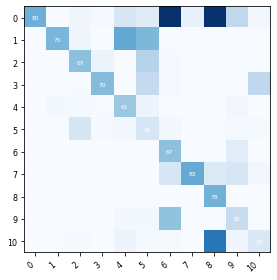

{'ACC': 0.71998450813323, 'ARI': 0.641208228191581, 'NMI': 0.6012796352400207, 'ACC Top-5': 0.9326103795507359, 'hungarian_match': [(0, 6), (1, 2), (2, 8), (3, 4), (4, 5), (5, 9), (6, 10), (7, 1), (8, 7), (9, 3), (10, 0)]}


In [229]:
print('Evaluate best model based on SCAN metric at the end')
model_checkpoint = torch.load("best_model.pt", map_location='cpu')
model.module.load_state_dict(model_checkpoint['model'])
predictions = get_predictions(val_dataloader, model)
clustering_stats = hungarian_evaluate(model_checkpoint['head'], predictions, 
                        class_names=[i for i in range(11)], 
                        compute_confusion_matrix=True, 
                        confusion_matrix_file=None)
print(clustering_stats)         

Evaluate best model based on SCAN metric at the end


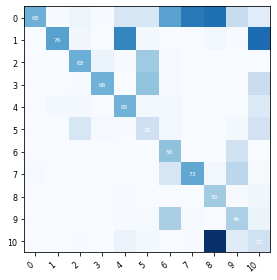

{'ACC': 0.67623701893708, 'ARI': 0.56996202329181, 'NMI': 0.5702427625288186, 'ACC Top-5': 0.9149358582773366, 'hungarian_match': [(0, 6), (1, 2), (2, 8), (3, 4), (4, 5), (5, 9), (6, 10), (7, 1), (8, 7), (9, 3), (10, 0)]}


In [230]:
print('Evaluate best model based on SCAN metric at the end')
model_checkpoint = torch.load("best_model.pt", map_location='cpu')
model.module.load_state_dict(model_checkpoint['model'])
predictions = get_predictions(test_dataloader, model)
clustering_stats = hungarian_evaluate(model_checkpoint['head'], predictions, 
                        class_names=[i for i in range(11)], 
                        compute_confusion_matrix=True, 
                        confusion_matrix_file=None)
print(clustering_stats)         